In [12]:
from cooltools import snipping
import cooler
import pandas as pd
import numpy as np
import pybedtools
import bioframe
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [13]:
plt.rcParams.update({'font.size': 16})
chromsizes=bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

binsDf=pd.read_csv('../data/genomeInfo/mm10bin5kb.bed',sep='\t',header=None,names=['chrom','start','end']) #bin file can be made with cooler makebins, binsize = 5000

signalFiles=glob.glob('../data/binnedBedgraphs/*')
signalDf=binsDf.copy()
for signalFile in signalFiles:
    signalDf=signalDf.merge(pd.read_csv(signalFile,sep="\t", header=None,names=['chrom','start','end',os.path.basename(signalFile).split('.')[0]]),how='left',on=['chrom','start','end'])
    signalDf.drop_duplicates(subset=['chrom','start','end'],inplace=True)
chromHMMdict={1:'H3K4me3', 
       2:'H3K4me1/3',
       3:'H3K4me1',
       4:'H3K4me1+\nH3K36me3',
       5:'H3K36me3',
       6:'Unmarked',
       7:'H3K27me3'}

In [14]:
def getPeakDf(peakFile):
    return pd.read_csv(peakFile,header=None,sep="\t",names=['chrom','start','end','name','score','strand','signalValue','pvalue','qvalue','peak'])

def chromhmmLabelPeakDf(peakDf,chromHmmFile='../data/chromhmm/ENCFF215ZKG_mm9mm10liftOver.bed'):
    peakCenterDf=pd.DataFrame(peakDf['chrom'])
    peakCenterDf['start']=(peakDf.start+peakDf.end)//2
    peakCenterDf['end']=peakCenterDf.start+1
    peakBt=pybedtools.bedtool.BedTool.from_dataframe(peakCenterDf)
    chromhmmBt=pybedtools.BedTool(chromHmmFile)
    return peakBt.intersect(chromhmmBt,wb=True).to_dataframe()[['chrom','start','end','thickStart']].rename(columns={'thickStart':'chromHMM'})

def getSplitQuantileDict(posListDict,splitOn,baseLabel="sites",splitLabel='CO'):
    quantiles=splitQuantile(posListDict,splitOn)
    return {f'{baseLabel} (all)':posListDict,
           f'{baseLabel} (top-{splitLabel})':quantiles[-1],
           f'{baseLabel} (bottom-{splitLabel})':quantiles[0]}

def splitQuantile(toSplit,splitOn,quantiles=4):
    quantileLims=np.linspace(0,len(toSplit),quantiles+1).astype(int)
    sortedArray=splitOn[toSplit].sort_values().index.to_numpy()
    quantiles=[sortedArray[quantileLims[ind]:quantileLims[ind+1]] for ind in range(quantiles)]
    return quantiles

def getPeakInds(peakFile,binsize=5000,flank=300000,supports=supports):
    if type(peakFile) is str:
        peakDf=pd.read_csv(peakFile,header=None,sep="\t",names=['chrom','start','end','name','score','strand','signalValue','pvalue','qvalue','peak'])
    elif type(peakFile) is pd.core.frame.DataFrame:
        peakDf=peakFile
    windows = snipping.make_bin_aligned_windows(
        binsize,
        peakDf['chrom'],
        (peakDf['start'] + peakDf['end'])//2,
        flank_bp=flank)
    windows=windows.merge(pd.DataFrame(supports,columns=['chrom','zero','chromsize']),how='left',on='chrom')
    windows=windows[(windows.end<windows.chromsize) & (windows.start>0)].drop_duplicates()
    windows=windows.loc[(windows.chrom!='chrX')&(windows.chrom!='chrY')&(windows.chrom!='chrM'),:]
    startInds=binsDf.reset_index().merge(windows[['chrom','start']],how='inner',on=['chrom','start'])['index']
    endInds=binsDf.reset_index().merge(windows[['chrom','end']],how='inner',on=['chrom','end'])['index']
    indDf=pd.DataFrame({'startInd':startInds,'endInd':endInds})
    return ((indDf.startInd+indDf.endInd)//2).values

def makeTracePlots(posListDict, signalLabelsDf, rowOrder=None,colOrder=None,palette=None, numBins=121, saveName=None, df=signalDf, avgType='median', xlabel='Relative position (kb)',aspectRatio=1.2, shareColAxes='stretch',titleString=None):
    if rowOrder is None:
        rowOrder=signalLabelsDf.row.unique()
    if colOrder is None:
        colOrder=signalLabelsDf.col.unique()
    halfBins=int((numBins-1)/2)
    windowAverageDf=pd.DataFrame([])
    genomeAverages=np.zeros(len(signalLabelsDf.index))
    for varInd in signalLabelsDf.index:
        var=signalLabelsDf.loc[varInd,'var']
        colLabel=signalLabelsDf.loc[varInd,'col']
        rowLabel=signalLabelsDf.loc[varInd,'row']
        if avgType=='mean':
            genomeAverages[varInd]=df[var].mean()
        elif avgType=='median':
            genomeAverages[varInd]=df[var].median()
        for posListInd,posListKey in enumerate(posListDict):
            posList=posListDict[posListKey]
            windowAverages=np.zeros((numBins,len(posList)))
            for posInd,pos in enumerate(posList):
                windowAverages[:,posInd]=df[var][pos-halfBins:pos+halfBins+1]
            windowDf=pd.DataFrame(windowAverages.T).stack().reset_index()
            windowDf.rename(columns={0: "Score"}, inplace=True)
            windowDf[xlabel]=5*(windowDf.level_1-halfBins)
            windowDf['ChIP-seq peaks']=posListKey
            windowDf['col']=colLabel
            windowDf['row']=rowLabel
            windowAverageDf=windowAverageDf.append(windowDf)
    signalLabelsDf['genomeAverages']=genomeAverages
    g=sns.relplot(x=xlabel,y="Score",data=windowAverageDf, col="col", row='row',hue="ChIP-seq peaks", 
                  row_order=rowOrder,col_order=colOrder,
                  ci=95, kind="line", palette=palette, height=2.7, aspect=aspectRatio, 
                  facet_kws={'sharey':False,'sharex':(shareColAxes=='yes'),'margin_titles':True})
    yMaxSubAvg=np.zeros((len(rowOrder),len(colOrder)))
    yMinSubAvg=np.zeros((len(rowOrder),len(colOrder)))
    for rowInd,row in enumerate(rowOrder):
        for colInd,col in enumerate(colOrder):
            genomeAverage=signalLabelsDf.loc[(signalLabelsDf.row==row)&(signalLabelsDf.col==col),'genomeAverages'].values[0]
            g.facet_axis(rowInd,colInd).axhline(y=genomeAverage, linestyle='--', color='grey', label='genome-wide '+avgType)
            yMaxSubAvg[rowInd,colInd]=g.facet_axis(rowInd,colInd).get_ylim()[1]-genomeAverage
            yMinSubAvg[rowInd,colInd]=g.facet_axis(rowInd,colInd).get_ylim()[0]-genomeAverage
    yMaxSubAvgLim=np.max(yMaxSubAvg, axis=1)
    yMinSubAvgLim=np.min(yMinSubAvg, axis=1)
    if shareColAxes=='stretch':
        for rowInd,row in enumerate(rowOrder):
            for colInd,col in enumerate(colOrder):
                genomeAverage=signalLabelsDf.loc[(signalLabelsDf.row==row)&(signalLabelsDf.col==col),'genomeAverages'].values[0]
                g.facet_axis(rowInd,colInd).set_ylim([genomeAverage+yMinSubAvgLim[rowInd],genomeAverage+yMaxSubAvgLim[rowInd]])

#     g.fig.tight_layout()

    plt.legend()
    if titleString is not None:
        plt.title(titleString)
    if saveName is not None:
        plt.savefig(saveName)


In [15]:
peakFiles=glob.glob('../data/peakBeds/*')
peakIndsDict=dict(zip([os.path.basename(file).split('.')[0] for file in peakFiles],[getPeakInds(file) for file in peakFiles]))
peakDfDict=dict(zip([os.path.basename(file).split('.')[0] for file in peakFiles],[getPeakDf(file) for file in peakFiles]))
saveDir='../outputs/'

In [16]:
pachyCTRsignalLabelsDf=pd.DataFrame({'var':['pachy_cisTotalRatio'],'row':[0],'col':[0]})

In [17]:
cohesinChromhmmLabelsDict={'Meiotic RAD21L':chromhmmLabelPeakDf(peakDfDict['vara2019_PDrad21l_peaks']),
                  'Meiotic REC8':chromhmmLabelPeakDf(peakDfDict['vara2019_PDrec8_peaks']),
                  'ES RAD21':chromhmmLabelPeakDf(peakDfDict['Nitzsche2011_ESC_RAD21_peaks'])}
cohesinChromhmmDfDict=dict([(key+":\n"+chromHMMdict[chromHMMstate],cohesinChromhmmLabelsDict[key][cohesinChromhmmLabelsDict[key].chromHMM==chromHMMstate][['chrom','start','end']]) for key in cohesinChromhmmLabelsDict for chromHMMstate in cohesinChromhmmLabelsDict[key].chromHMM.unique()])
cohesinChromhmmDfDictList=[dict([(key,cohesinChromhmmDfDict[key]) for key in cohesinChromhmmDfDict.keys() if key.split(":\n")[1]==chromHMMstate]) for chromHMMstate in chromHMMdict.values()]

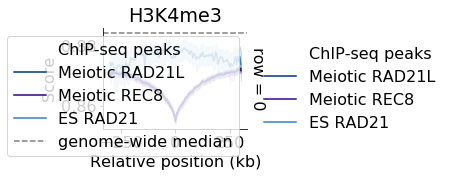

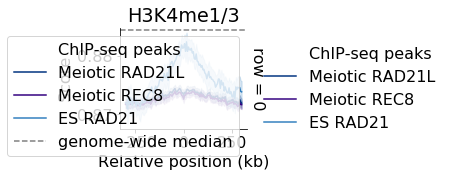

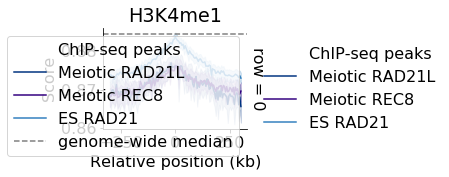

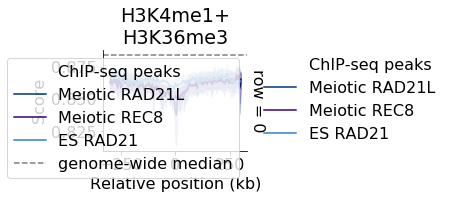

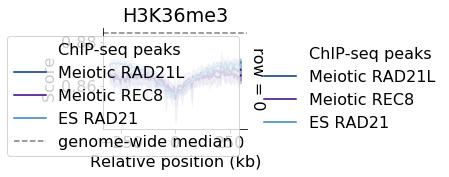

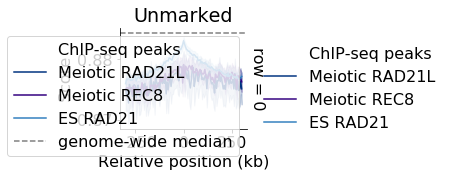

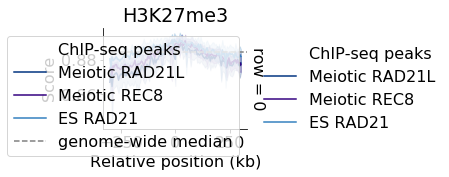

In [18]:
for cohesinChromhmmDfDict in cohesinChromhmmDfDictList:
    peakIndsDict=dict([(key.split(":\n")[0],getPeakInds(cohesinChromhmmDfDict[key])) for key in cohesinChromhmmDfDict])
    titleString=list(cohesinChromhmmDfDict.keys())[0].split(":\n")[1]
    chromHMMstate=titleString.replace("/","_").replace("\n","_")
    makeTracePlots(peakIndsDict, pachyCTRsignalLabelsDf,aspectRatio=1.5, palette=[(0,0.2,0.5),(0.2,0,0.5),(0.2,0.5,0.75)],
                   saveName=f"{saveDir}/cohesinsChromhmm_{chromHMMstate}_pachyCTRtraceplot.pdf",titleString=titleString)

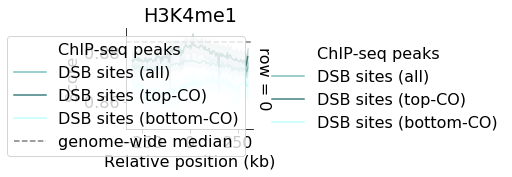

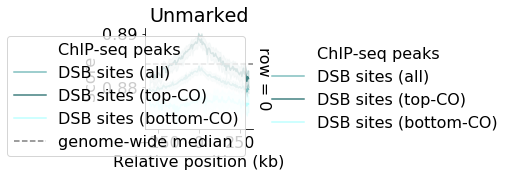

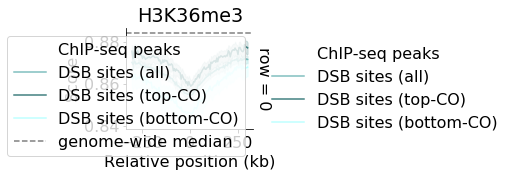

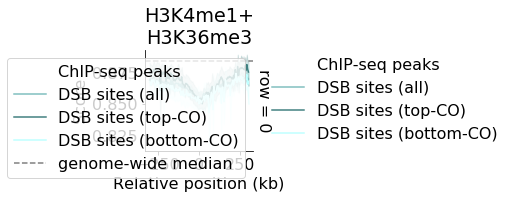

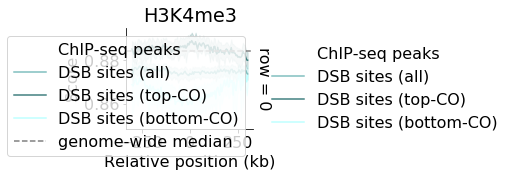

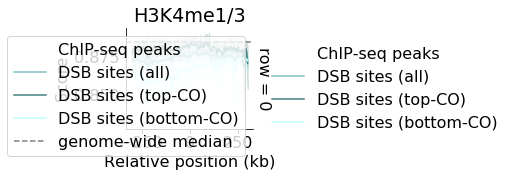

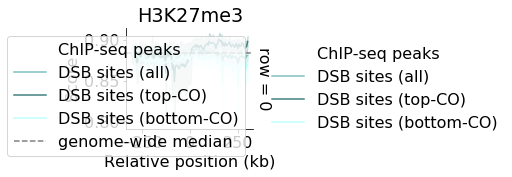

In [19]:
DSBpeakChromHMMDf=chromhmmLabelPeakDf(peakDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'])
DSBpeakChromHMMDfDict=dict([(chromHMMdict[chromHMMstate],DSBpeakChromHMMDf[DSBpeakChromHMMDf.chromHMM==chromHMMstate][['chrom','start','end']]) for chromHMMstate in DSBpeakChromHMMDf.chromHMM.unique()])
DSBpeakChromHMMPeakIndsDictCOsplit=dict([(key,getSplitQuantileDict(posListDict=getPeakInds(DSBpeakChromHMMDfDict[key]),splitOn=signalDf.yin2019_crossoversCast1C_binned_weightedScore_medianNormalized,baseLabel="DSB sites",splitLabel='CO')) for key in DSBpeakChromHMMDfDict])
for key in DSBpeakChromHMMPeakIndsDictCOsplit:
    chromHMMstate=key.replace("/","_").replace("\n","_")
    makeTracePlots(DSBpeakChromHMMPeakIndsDictCOsplit[key], pachyCTRsignalLabelsDf,aspectRatio=1.5, palette=[(0.5,0.75,0.75),(0.25,0.5,0.5),(0.75,1,1)],
                   saveName=f"{saveDir}/DSBsplitCO_chromhmm_{chromHMMstate}_pachyCTRtraceplot.pdf",titleString=key)